In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve

<h3>Задание: </h3>

 1. для подсчета Accuracy
    
 2. для подсчета Матрицы ошибок
 
 3. для подсчета Точности и полноты, F1 score
 
 4. для подсчета и построения ROC-кривой

In [232]:
# Cгенерируем тестовые данны для оценки
np.random.seed(43) # Сегодня будет 43...

# Генерируем случайный сет
data_random = pd.Series(np.random.random_sample(100))

# Тестовые данные обычным округлением
data = pd.DataFrame(np.round(data_random), columns=['Test']).astype(int)

# Генерируем предсказанные данные, будем считать что наша модель - случайное число 0..1 в квадрате
predict = data_random * pd.Series(np.random.random_sample(100))**2

# 'Предсказанные' данные округлением со смещением границы
data['Predict'] = predict

In [233]:
data.head() # Получим фрейм для работы

,Test,Predict
0,0,0.001229
1,1,0.146302
2,0,0.000267
3,0,0.023364
4,0,0.185018


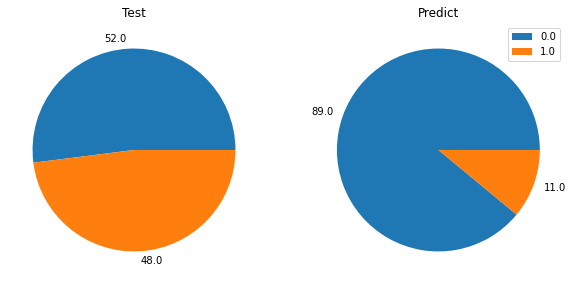

In [234]:
# Посмотрим на графике на сгенерированные данные

fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
axs[0].pie(data['Test'].value_counts(), 
        labels= data['Test'].value_counts() * 100 / len(data['Test']))

axs[0].set_title('Test')

axs[1].pie(round(data['Predict']).value_counts(), 
        labels= round(data['Predict']).value_counts() * 100 / len(data['Test']))

axs[1].set_title('Predict')

fig.set_figheight(5)
fig.set_figwidth(10)
plt.legend(round(data['Predict']).value_counts().index)
plt.show()


<h4>Подготовим базовый класс с функционалом расчета:

In [235]:
class Metrics():
    '''
    Содержит функции расчета метрик
    Словарь для хранения результатов
    '''
    def __init__(self):
        
        # Тут храним перечень функций в которые умеет класс
        self.operations = {
            self.find_accuracy: 'Accuracy score',
            self.find_matrix: 'Cconfusion matrix',
            self.find_fscore: 'F-score',
            self.find_precision: 'Precision',
            self.find_recall: 'Recall',
            self.find_roc_auc: 'ROC-AUC-score'
        }
        
        # Тут храним результаты
        self.results = {}
        
        # Фрейм, переопределить в дочернем классе
        self.test_data = pd.DataFrame()
        self.predict_data = pd.DataFrame()
        self.predict_pr = pd.DataFrame()
        
        
    def find_accuracy(self):
        # Cчитаем accuracy
        count_tp = len(self.predict_data[self.test_data == self.predict_data])
        
        accuracy = count_tp / len(self.test_data)
        self.results['accuracy'] = accuracy
        return accuracy 
    
    def find_matrix(self):
        # Cчитаем confusion matrix
        self.TP = len(self.predict_data[self.predict_data == 1][self.test_data == 1])
        self.FP = len(self.predict_data[self.predict_data == 1][self.test_data == 0])
        self.TN = len(self.predict_data[self.predict_data == 0][self.test_data == 0])
        self.FN = len(self.predict_data[self.predict_data == 0][self.test_data == 1])
        
        confusion = np.array([[self.TN, self.FP], [self.FN, self.TP]])
        
        self.results['confusion'] = confusion
        return confusion
    
    def find_fscore(self, beta=1):
        # Cчитаем fscore
        # 2*TP / (2 * TP + FP + FN) 
        f_score = 2 * self.TP / (2 * self.TP + self.FP + self.FN)
        
        self.results['f-score'] = f_score
        
        return f_score
    
    def find_precision(self):
        # Cчитаем precision
        precision = self.TP / (self.TP + self.FP)
        
        self.results['precision'] = precision
        
        return precision
    
    def find_recall(self):
        # Cчитаем recall
        recall = self.TP / (self.TP + self.FN)
        
        self.results['recall'] = recall
        
        return recall
    
    def find_roc_auc(self, n=1000):
        # Вычисляем точки ROC и сохраняем данные в словарь
        # Cчитаем ROC_AUC score, сохраняем точки графика в ROC_auc_score
        
        # Сначала делим график на n отрезков
        bins = np.arange(min(self.test_data), max(self.test_data), round((max(self.test_data) - min(self.test_data))/n, 5))
        tpr_list = []
        fpr_list = []
        thresholds_list = []
        area_list = []
        
        # Для каждой отсечки считаем  TPR и FPR
        for threshold in bins:
            temp = self.predict_pr.copy()
            temp = temp.where(temp > threshold, 0)
            temp = temp.where(temp == 0, 1)

            TP = len(temp[temp == 1][self.test_data == 1])
            FP = len(temp[temp == 1][self.test_data == 0])
            TN = len(temp[temp == 0][self.test_data == 0])
            FN = len(temp[temp == 0][self.test_data == 1])

            TPR = TP / (TP + FN)
            FPR = FP / (FP + TN)
            
            # Сохраняем только уникальные точки
            if TPR not in tpr_list or FPR not in fpr_list:
                tpr_list.append(TPR)
                fpr_list.append(FPR)
                thresholds_list.append(threshold)
        
        # Считаем площадь под графиком
        start_fpr = 0
        for fpr, tpr in zip(fpr_list, tpr_list):
            area_list.append((fpr - start_fpr) * tpr)
            start_fpr = fpr
        
        auc = 1 - sum(area_list)
        
        # Пишем в словарь
        self.results['ROC_AUC_score'] = auc
        self.results['ROC_fpr'] = fpr_list
        self.results['ROC_tpr'] = tpr_list
        self.results['ROC_thresholds'] = thresholds_list
        
        return fpr_list, tpr_list, thresholds_list, auc  


<h4>Подготовим класс - калькулятор</h4>

Через него будем работать с данными

In [244]:
class MetricsCalc(Metrics):
    '''
    Функции для работы с классом
    Функции для обработки данных
    Функции для отрисовки метрик
    Логирование
    '''
    
        
    def fit(self, test_data, predict_data):
        # Загружаем данные
        # Обычно тут нужно реализовать проверку и чистку данных, сейчас не будем так как данные сгенерированы
        self.test_data = test_data
        self.predict_data = round(predict_data)
        self.predict_pr = predict_data
    
    def train(self):
        # Выполняем весь функционал расчета с логированием операций
        for operation in self.operations:
            print(f'Выполняю расчет: {self.operations[operation]}')
            operation()
            print('Выполнено\n')
        
        # Выполняем проверку результатов
        self.check_calc()
        
        # Рисуем графики
        self.show_results()
    
    def check_calc(self):
        check = accuracy_score(self.test_data, self.predict_data)
        
        print(f'''
        Пункт 1:
        Проверяем Accuracy: {"Ок" if round(check, 5) == round(self.results['accuracy'], 5) else "Ошибка<--------"}
        Верно:     {round(check, 5)}
        Посчитано: {round(self.results['accuracy'], 5)}
        ''')
        
        check = confusion_matrix(self.test_data, self.predict_data)
        
        print(f'''
        Пункт 2:
        Проверяем Confusion Matrix: {"Ок" if all(check.flatten() == self.results['confusion'].flatten()) else "Ошибка<--------"}
                    TN FN FP TP
        Верно:     {check.flatten()}
        Посчитано: {self.results['confusion'].flatten()}
        ''')
        
        print(f'''
        Пункт 3:
        Проверяем F-score: {"Ок" if round(fbeta_score(self.test_data, 
                                                    self.predict_data, 
                                                    beta=1), 5) == round(self.results['f-score'], 5) else "Ошибка<--------"}
        Верно:     {round(fbeta_score(self.test_data, self.predict_data, beta=1), 5)}
        Посчитано: {round(self.results['f-score'], 5)}
        ''')
        
        print(f'''
        Проверяем Precision: {"Ок" if round(fbeta_score(self.test_data, 
                                                    self.predict_data, 
                                                    beta=0), 5) == round(self.results['precision'], 5) else "Ошибка<--------"}
        Верно:     {round(fbeta_score(self.test_data, self.predict_data, beta=0), 5)}
        Посчитано: {round(self.results['precision'], 5)}
        ''')

        print(f'''
        Проверяем Recall: {"Ок" if round(fbeta_score(self.test_data, 
                                                    self.predict_data, 
                                                    beta=10000), 5) == round(self.results['recall'], 5) else "Ошибка<--------"}
        Верно:     {round(fbeta_score(self.test_data, self.predict_data, beta=10000), 5)}
        Посчитано: {round(self.results['recall'], 5)}
        ''')
        
        print(f'''
        Пункт 4:
        Проверяем ROC AUC score: {"Ок" if round(roc_auc_score(self.test_data, self.predict_pr), 2) == round(self.results['ROC_AUC_score'], 2) else "Ошибка<--------"}
        Верно:     {round(roc_auc_score(self.test_data, self.predict_pr), 2)}
        Посчитано: {round(self.results['ROC_AUC_score'], 2)}
        ''')
    
    def show_results(self):
        # Отрисовка результатов
        
        # Проверочная кривая
        fpr_check, tpr_check, t = roc_curve(self.test_data, self.predict_pr)
        
        #Отображаем нашу кривую и проверочную
        plt.figure(figsize=(10, 6))
        plt.plot(self.results['ROC_fpr'], 
                 self.results['ROC_tpr'], 
                 color='darkorange', 
                 lw=4, 
                 label='ROC curve (area = %0.2f)' % self.results['ROC_AUC_score'])
        
        plt.plot(fpr_check, 
                 tpr_check, 
                 color='blue', 
                 lw=1, 
                 label=' Control curve (area = %0.2f)' % roc_auc_score(self.test_data, self.predict_pr))
                 
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
    

<h3>Теперь когда функционал калькулятора написан, выполним расчет по всем пунктам с проверкой</h3>

In [245]:
calc = MetricsCalc()

In [246]:
calc.fit(data['Test'], predict)

Выполняю расчет: Accuracy score
Выполнено

Выполняю расчет: Cconfusion matrix
Выполнено

Выполняю расчет: F-score
Выполнено

Выполняю расчет: Precision
Выполнено

Выполняю расчет: Recall
Выполнено

Выполняю расчет: ROC-AUC-score
Выполнено


        Пункт 1:
        Проверяем Accuracy: Ок
        Верно:     0.59
        Посчитано: 0.59
        

        Пункт 2:
        Проверяем Confusion Matrix: Ок
                    TN FN FP TP
        Верно:     [48  0 41 11]
        Посчитано: [48  0 41 11]
        

        Пункт 3:
        Проверяем F-score: Ок
        Верно:     0.34921
        Посчитано: 0.34921
        

        Проверяем Precision: Ок
        Верно:     1.0
        Посчитано: 1.0
        

        Проверяем Recall: Ок
        Верно:     0.21154
        Посчитано: 0.21154
        

        Пункт 4:
        Проверяем ROC AUC score: Ок
        Верно:     0.75
        Посчитано: 0.75
        


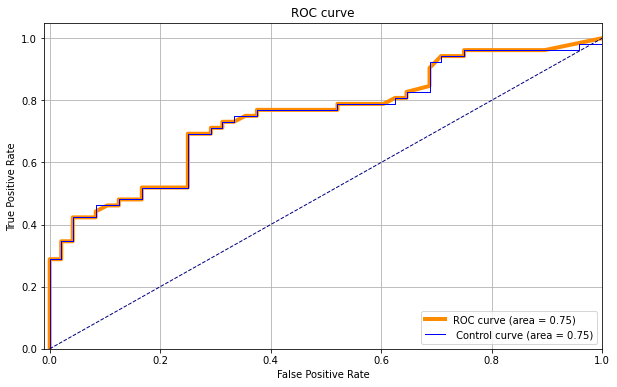

In [247]:
calc.train()

<h3> Отчет и результаты: </h3>

- Сгенерировал реальные и проверяемые данные
- Написал класс - обработчик с требуемыми функциями
- Каждую функцию проверил сверкой с контрольным рассчетом
- Посчитал ROC кривую и ROC_AUC, проверил контрольным рассчетом численно и графиком
